In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from aesara import tensor as at

import pymc_experimental as pmx

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your Python environment has Theano(-PyMC) 1.1.2 installed, but you are importing PyMC 4.0.0 which uses Aesara as its backend.
For PyMC 4.0.0 to work as expected you should uninstall Theano(-PyMC).
See https://github.com/pymc-devs/pymc/wiki for update instructions.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
You are importing PyMC 4.0.0, but your environment also has the legacy version PyMC3 3.11.2 installed.
For PyMC 4.0.0 to work as expected you should uninstall PyMC3.
See https://github.com/pymc-devs/pymc/wiki for update instructions.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3


In [2]:
from pymc_experimental.gp import HSGP, KarhunenLoeveExpansion, ProjectedProcess
from pymc_experimental.gp.latent_approx import ExpQuad, Matern12, Matern32, Matern52

In [3]:
eta_t = 1.0
ell_t = 1.0
cov_t = eta_t ** 2 * pm.gp.cov.ExpQuad(1, ls=ell_t)

x = np.linspace(0, 20, 20)
x_cond = np.linspace(0, 20, 100)
x_all = np.concatenate([x, x_cond])
rng = np.random.default_rng(seed=42)
f_all = rng.multivariate_normal(
    np.zeros(len(x_all)), cov_t(x_all[:, None]).eval(), 1
).flatten()
f = f_all[: len(x)]
f_cond_true = f_all[len(x) :]

sigma_t = 0.1
y = f + sigma_t * rng.normal(size=len(x))

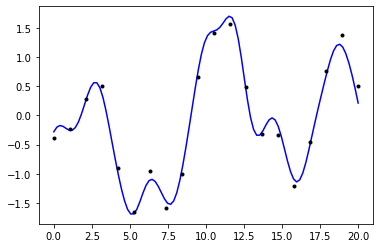

In [4]:
plt.plot(x_cond, f_cond_true, color="b")
plt.plot(x, y, "k.");

# Karhunen Loeve Expansion

In [5]:
%%time

with pm.Model() as model:
    eta = eta_t
    ell = ell_t
    cov = eta ** 2 * pm.gp.cov.ExpQuad(1, ls=ell)
    gp = KarhunenLoeveExpansion(n_eigs=15, cov_func=cov)

    f = gp.prior("f", X=x[:, None])

    sigma = pm.HalfNormal("sigma", sd=1)
    pm.Normal("lik", mu=f, sd=sigma, observed=y)

with model:
    tr = pm.sample(target_accept=0.9)

with model:
    f_cond = gp.conditional("f_cond", x_cond[:, None])
    ppc = pm.sample_posterior_predictive(tr, var_names=["f_cond"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/lpaz/repos/pymc3/pymc/model.py:925: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [_gp_f_coefs, sigma]
/home/lpaz/repos/pymc3/pymc/model.py:925: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


CPU times: user 14.2 s, sys: 255 ms, total: 14.5 s
Wall time: 12.4 s


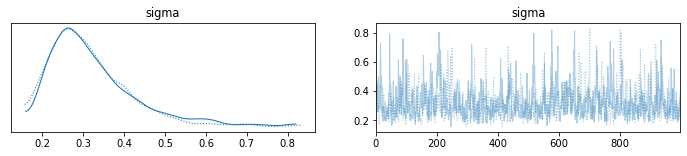

In [6]:
pm.plot_trace(tr, var_names=["sigma"]);

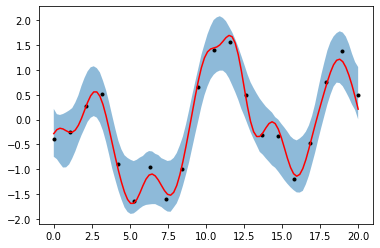

In [7]:
f = ppc.posterior_predictive["f_cond"].stack({"f": ["chain", "draw"]}).values
upper = np.percentile(f, 95, axis=1)
lower = np.percentile(f, 5, axis=1)

plt.plot(x, y, "k.")
plt.plot(x_cond, f_cond_true, "-r")
plt.fill_between(x_cond, lower, upper, alpha=0.5);

# Projected Process / DTC

In [8]:
%%time

with pm.Model() as model:
    eta = pm.HalfNormal("eta", sd=1)
    ell = pm.Gamma("ell", alpha=2, beta=1)
    cov = eta ** 2 * ExpQuad(1, ls=ell)
    gp = ProjectedProcess(n_inducing=15, cov_func=cov)

    f = gp.prior("f", X=x[:, None])

    sigma = pm.HalfNormal("sigma", sd=1)
    pm.Normal("lik", mu=f, sd=sigma, observed=y)

with model:
    tr = pm.sample(target_accept=0.9)

with model:
    f_cond = gp.conditional("f_cond", x_cond[:, None])
    ppc = pm.sample_posterior_predictive(tr, var_names=["f_cond"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/lpaz/repos/pymc3/pymc/model.py:925: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eta, ell, f_u_rotated_, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 31 seconds.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6343, but should be close to 0.9. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 20 s, sys: 424 ms, total: 20.4 s
Wall time: 45.3 s


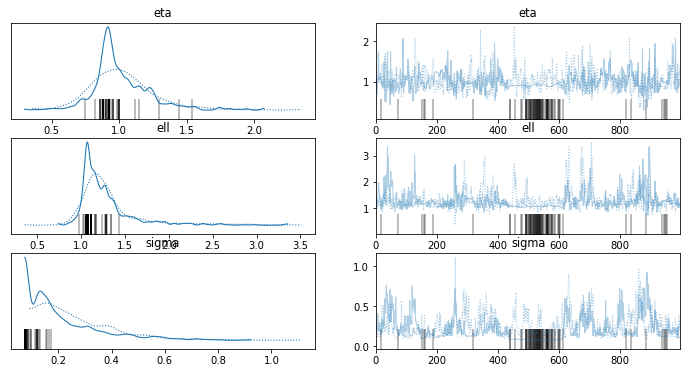

In [9]:
pm.plot_trace(tr, var_names=["eta", "ell", "sigma"]);

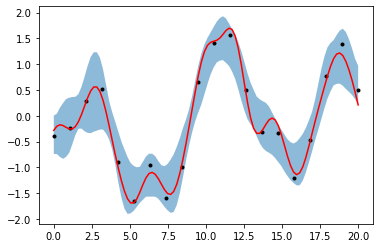

In [10]:
f = ppc.posterior_predictive["f_cond"].stack({"f": ["chain", "draw"]}).values
upper = np.percentile(f, 95, axis=1)
lower = np.percentile(f, 5, axis=1)

plt.plot(x, y, "k.")
plt.plot(x_cond, f_cond_true, "-r")
plt.fill_between(x_cond, lower, upper, alpha=0.5);

# Hilbert Space GP (HSGP)

In [11]:
%%time

with pm.Model() as model:
    eta = pm.HalfNormal("eta", sd=1)
    ell = pm.Gamma("ell", alpha=2, beta=1)
    cov = eta ** 2 * ExpQuad(1, ls=ell)
    gp = HSGP(n_basis=20, cov_func=cov)

    f = gp.prior("f", X=x[:, None])

    sigma = pm.HalfNormal("sigma", sd=1)
    pm.Normal("lik", mu=f, sd=sigma, observed=y)

with model:
    tr = pm.sample(target_accept=0.9)

with model:
    f_cond = gp.conditional("f_cond", x_cond[:, None])
    ppc = pm.sample_posterior_predictive(tr, var_names=["f_cond"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/lpaz/repos/pymc3/pymc/model.py:925: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eta, ell, f_coeffs_, sigma]
/home/lpaz/repos/pymc3/pymc/model.py:925: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
The number of effective samples is smaller than 25% for some parameters.


CPU times: user 6.65 s, sys: 247 ms, total: 6.9 s
Wall time: 17.9 s


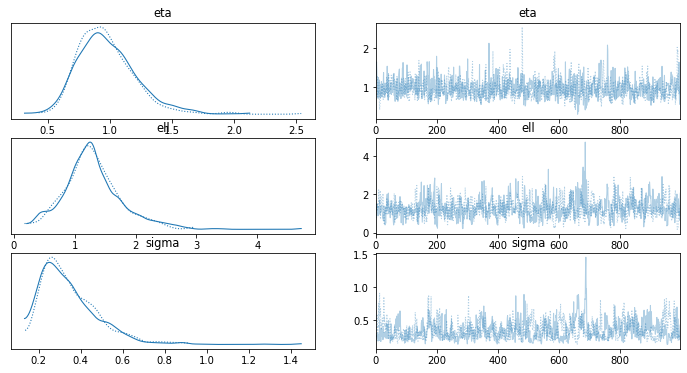

In [12]:
pm.plot_trace(tr, var_names=["eta", "ell", "sigma"]);

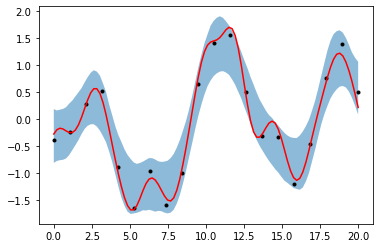

In [13]:
f = ppc.posterior_predictive["f_cond"].stack({"f": ["chain", "draw"]}).values
upper = np.percentile(f, 95, axis=1)
lower = np.percentile(f, 5, axis=1)

plt.plot(x, y, "k.")
plt.plot(x_cond, f_cond_true, "-r")
plt.fill_between(x_cond, lower, upper, alpha=0.5);